In [1]:
import os
import sys
import dateutil.parser
import dateutil.relativedelta as dateutil_rd

spark_path = "C:/opt/spark"

os.environ['SPARK_HOME'] = spark_path
os.environ['HADOOP_HOME'] = spark_path

sys.path.append(spark_path + "/bin")
sys.path.append(spark_path + "/python")
sys.path.append(spark_path + "/python/pyspark/")
sys.path.append(spark_path + "/python/lib")
sys.path.append(spark_path + "/python/lib/pyspark.zip")
sys.path.append(spark_path + "/python/lib/py4j-0.9-src.zip")

from pyspark import SparkContext
from pyspark import SparkConf
from pyspark import SQLContext

sc = SparkContext("local", "test")
sqlContext = SQLContext(sc)

In [2]:
print(sc)
print(sqlContext)

In [3]:
%%javascript
/**********************************************************************************************
Known Mathjax Issue with Chrome - a rounding issue adds a border to the right of mathjax markup
https://github.com/mathjax/MathJax/issues/1300
A quick hack to fix this based on stackoverflow discussions: 
http://stackoverflow.com/questions/34277967/chrome-rendering-mathjax-equations-with-a-trailing-vertical-line
**********************************************************************************************/

$('.math>span').css("border-left-color","transparent")

<IPython.core.display.Javascript object>

In [4]:
%reload_ext autoreload
%autoreload 2
%pdb

Automatic pdb calling has been turned ON


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric import smoothers_lowess
from pandas import Series, DataFrame
from patsy import dmatrices, ModelDesc
from sklearn import datasets, svm

In [6]:
df = pd.read_csv("daquiri15.csv",parse_dates=[0]) 
df2 = pd.read_csv("daquiri_test.csv",parse_dates=[0])

df['event_min'] = df['event_min'].map({1:14, 2:29, 3:44, 4:59})
df2['event_min'] = df2['event_min'].map({1:14, 2:29, 3:44, 4:59})

df['event_ts'] = df['event_dt'].astype(str)+' '+df['event_hr'].astype(str)+':'+df['event_min'].astype(str)+':59.999999'
df2['event_ts'] = df2['event_dt'].astype(str)+' '+df2['event_hr'].astype(str)+':'+df2['event_min'].astype(str)+':59.999999'
df['event_ts'] = pd.to_datetime(df['event_ts'])
df2['event_ts'] = pd.to_datetime(df2['event_ts'])

cols = df.columns.tolist()
cols = ['event_ts']  + [col for col in df if col != 'event_ts']
df = df[cols]

cols = df2.columns.tolist()
cols = ['event_ts']  + [col for col in df2 if col != 'event_ts']
df2 = df2[cols]



In [7]:
df.head()

,event_ts,event_dt,event_hr,event_min,unq_visitors,unq_ip,cookie_disabl_true,sign_in_rem,sign_in_no,sign_in_unk,...,lvl4_cnt,pgld_cnt,atp_cnt,rec_cnt,click_cnt,tcin_cnt,compld_cnt,event_cnt,demand_sales,order_cnt
0,2016-07-10 17:14:59.999999,2016-07-10,17,14,79323,431075,0,45298,563581,33067,...,25116,399484,74185,250690,18357,41400,1927,786043,172020.32990,2496
1,2016-07-11 07:14:59.999999,2016-07-11,7,14,18465,99632,0,12043,143508,8807,...,7486,100790,20635,65242,5049,11226,548,203490,32150.23004,507
2,2016-07-10 06:59:59.999999,2016-07-10,6,59,20935,105836,0,15895,159932,9426,...,8977,115883,22273,72429,5459,11757,437,228238,67797.87003,611
3,2016-07-10 07:14:59.999999,2016-07-10,7,14,20019,101279,0,12642,144108,8190,...,7172,102434,19918,65288,4769,10284,391,203084,31261.28998,412
4,2016-07-10 19:29:59.999999,2016-07-10,19,29,83036,403254,0,51072,602666,38016,...,27948,430151,83378,271379,19896,48860,2069,855733,184884.81020,2718


In [8]:
df2.head()

,event_ts,event_dt,event_hr,event_min,unq_visitors,unq_ip,cookie_disabl_true,sign_in_rem,sign_in_no,sign_in_unk,...,lvl4_cnt,pgld_cnt,atp_cnt,rec_cnt,click_cnt,tcin_cnt,compld_cnt,event_cnt,demand_sales,order_cnt
0,2016-09-15 21:44:59.999999,2016-09-15,21,44,82308,512742,0,106636,640399,23924,...,27307,409644,127686,202029,18310,60689,4305,822663,175572.08030,2708
1,2016-09-13 21:29:59.999999,2016-09-13,21,29,86866,581704,0,126998,697536,28117,...,31764,463714,143593,209060,19245,69994,2791,908397,194231.02070,2678
2,2016-09-14 11:29:59.999999,2016-09-14,11,29,40683,228464,0,38002,262929,125548,...,11397,274122,51468,77998,7235,26072,1076,437971,37814.11014,637
3,2016-09-15 01:29:59.999999,2016-09-15,1,29,96172,665998,0,156889,798431,36219,...,41267,536773,169058,238301,21639,85398,2962,1054131,202202.04030,2967
4,2016-09-12 23:29:59.999999,2016-09-12,23,29,88126,615960,0,127390,717299,39355,...,31754,480576,149851,214626,20242,73462,2601,941358,168464.42030,2552


In [9]:
df = df.drop('cookie_disabl_true', axis=1)
df = df.drop('wkly_ad_cnt',axis=1)
df = df.dropna()
df['dayofwk'] = df['event_dt'].dt.dayofweek

df2 = df2.drop('cookie_disabl_true', axis=1)
df2 = df2.drop('pgvw_cnt',axis=1)
df2 = df2.drop('wkly_ad_cnt',axis=1)
df2 = df2.dropna()
df2['dayofwk'] = df2['event_dt'].dt.dayofweek

In [10]:
cols = df.columns.tolist()
cols = ['event_cnt']  + [col for col in df if col != 'event_cnt']
df = df[cols]
l1 = len(cols)
df.head()


,event_cnt,event_ts,event_dt,event_hr,event_min,unq_visitors,unq_ip,sign_in_rem,sign_in_no,sign_in_unk,...,lvl4_cnt,pgld_cnt,atp_cnt,rec_cnt,click_cnt,tcin_cnt,compld_cnt,demand_sales,order_cnt,dayofwk
0,786043,2016-07-10 17:14:59.999999,2016-07-10,17,14,79323,431075,45298,563581,33067,...,25116,399484,74185,250690,18357,41400,1927,172020.32990,2496,6
1,203490,2016-07-11 07:14:59.999999,2016-07-11,7,14,18465,99632,12043,143508,8807,...,7486,100790,20635,65242,5049,11226,548,32150.23004,507,0
2,228238,2016-07-10 06:59:59.999999,2016-07-10,6,59,20935,105836,15895,159932,9426,...,8977,115883,22273,72429,5459,11757,437,67797.87003,611,6
3,203084,2016-07-10 07:14:59.999999,2016-07-10,7,14,20019,101279,12642,144108,8190,...,7172,102434,19918,65288,4769,10284,391,31261.28998,412,6
4,855733,2016-07-10 19:29:59.999999,2016-07-10,19,29,83036,403254,51072,602666,38016,...,27948,430151,83378,271379,19896,48860,2069,184884.81020,2718,6


In [11]:
cols = df2.columns.tolist()
cols = ['event_cnt']  + [col for col in df2 if col != 'event_cnt']
df2 = df2[cols]
df2.head()

,event_cnt,event_ts,event_dt,event_hr,event_min,unq_visitors,unq_ip,sign_in_rem,sign_in_no,sign_in_unk,...,lvl4_cnt,pgld_cnt,atp_cnt,rec_cnt,click_cnt,tcin_cnt,compld_cnt,demand_sales,order_cnt,dayofwk
0,822663,2016-09-15 21:44:59.999999,2016-09-15,21,44,82308,512742,106636,640399,23924,...,27307,409644,127686,202029,18310,60689,4305,175572.08030,2708,3
1,908397,2016-09-13 21:29:59.999999,2016-09-13,21,29,86866,581704,126998,697536,28117,...,31764,463714,143593,209060,19245,69994,2791,194231.02070,2678,1
2,437971,2016-09-14 11:29:59.999999,2016-09-14,11,29,40683,228464,38002,262929,125548,...,11397,274122,51468,77998,7235,26072,1076,37814.11014,637,2
3,1054131,2016-09-15 01:29:59.999999,2016-09-15,1,29,96172,665998,156889,798431,36219,...,41267,536773,169058,238301,21639,85398,2962,202202.04030,2967,3
4,941358,2016-09-12 23:29:59.999999,2016-09-12,23,29,88126,615960,127390,717299,39355,...,31754,480576,149851,214626,20242,73462,2601,168464.42030,2552,0


In [12]:
df.dtypes

event_cnt                 int64
event_ts         datetime64[ns]
event_dt         datetime64[ns]
event_hr                  int64
event_min                 int64
unq_visitors              int64
unq_ip                    int64
sign_in_rem               int64
sign_in_no                int64
sign_in_unk               int64
windows_os                int64
iphone_os                 int64
mac_os                    int64
ipad_os                   int64
android_os                int64
mweb_cnt                  int64
prod_dtl_cnt              int64
pgvw_cnt                  int64
srch_rslt_cnt             int64
homepg_cnt                int64
shp_crt_cnt               int64
crt_ovrly_cnt             int64
lvl1_cnt                  int64
lvl2_cnt                  int64
lvl3_cnt                  int64
lvl4_cnt                  int64
pgld_cnt                  int64
atp_cnt                   int64
rec_cnt                   int64
click_cnt                 int64
tcin_cnt                  int64
compld_c

In [13]:
df['dayofwk'] = df['dayofwk'].astype(object)
df2['dayofwk'] = df2['dayofwk'].astype(object)

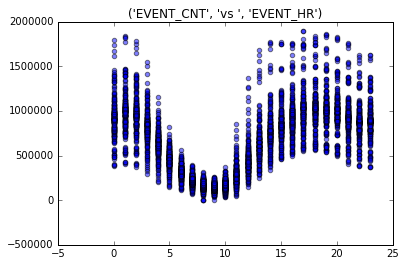

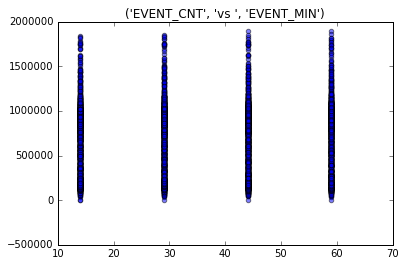

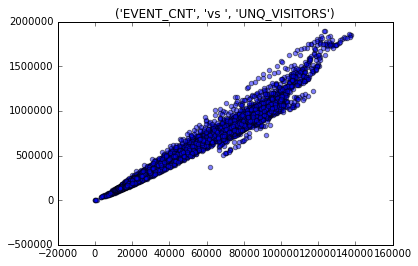

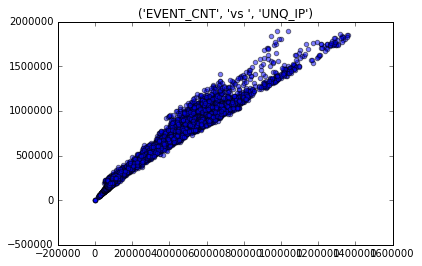

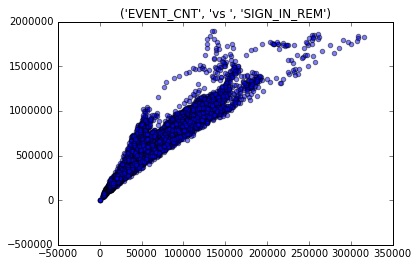

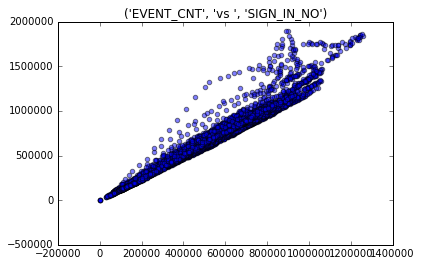

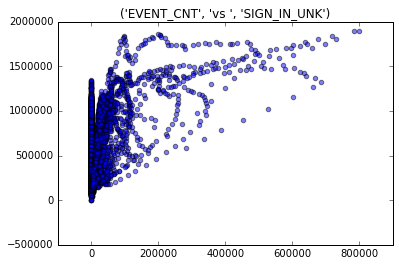

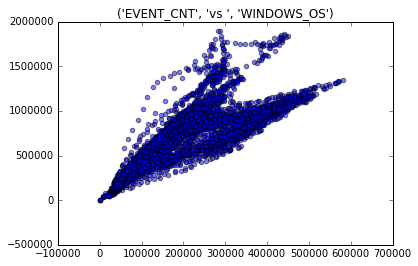

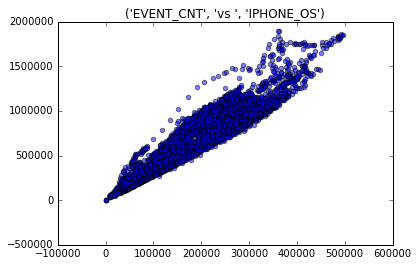

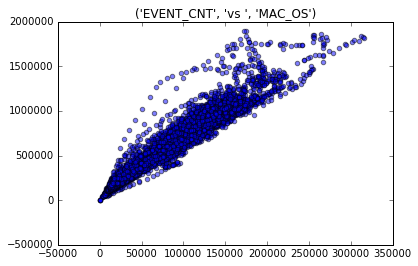

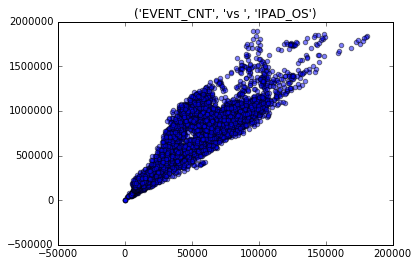

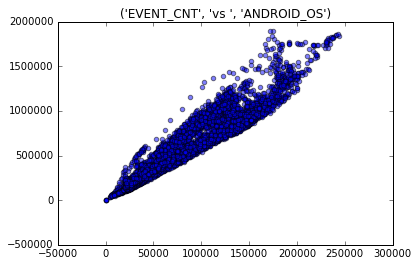

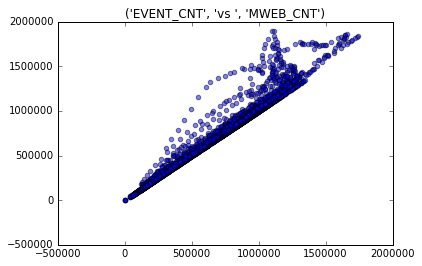

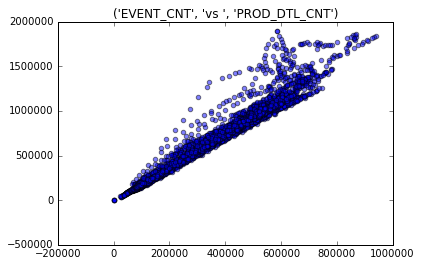

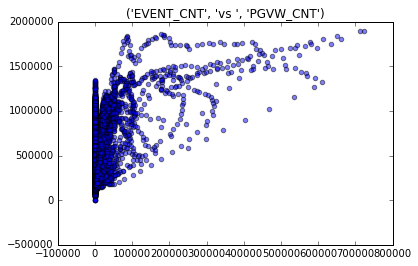

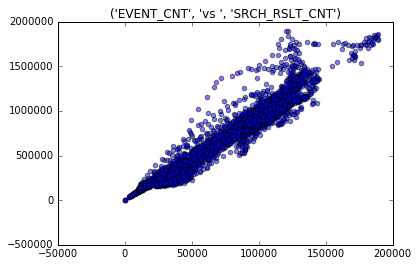

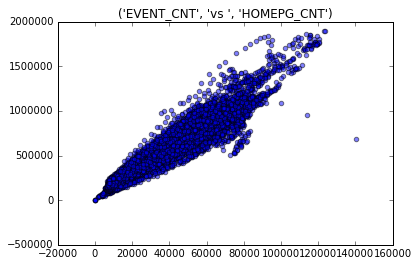

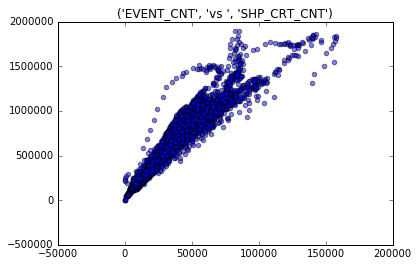

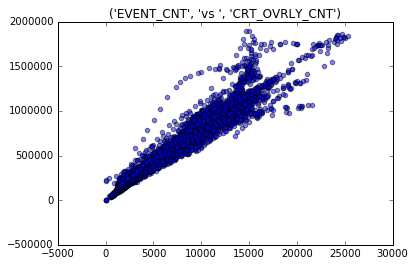

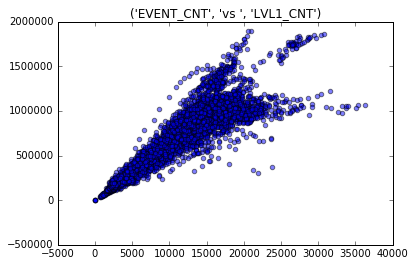

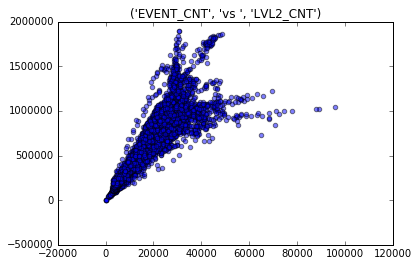

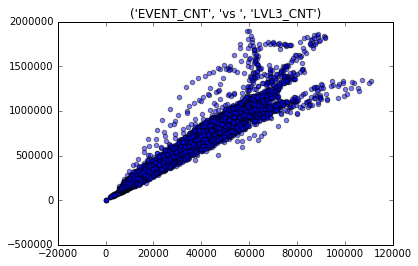

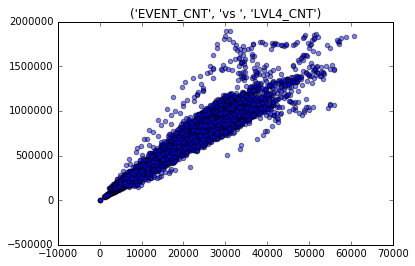

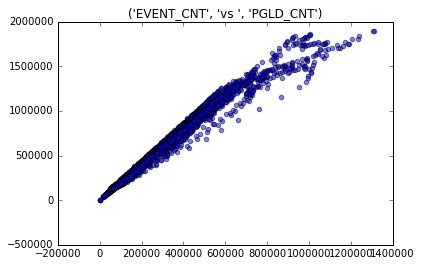

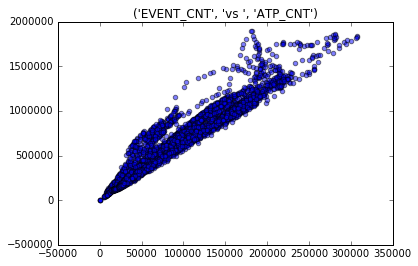

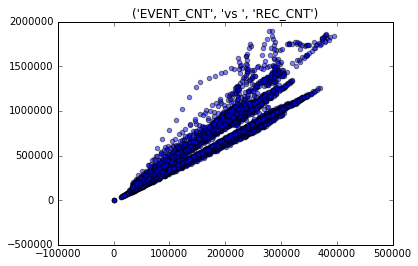

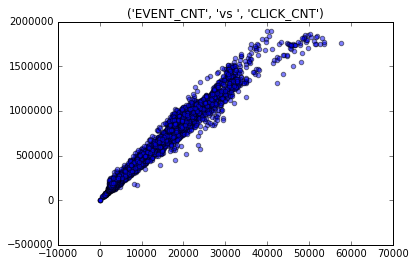

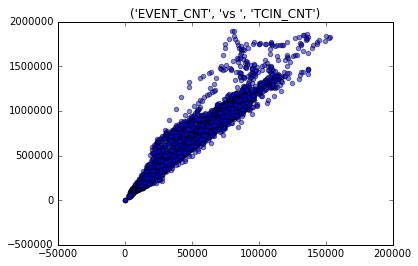

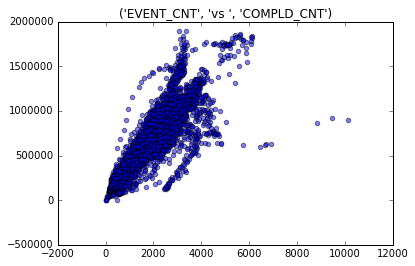

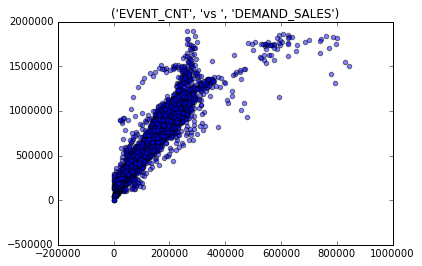

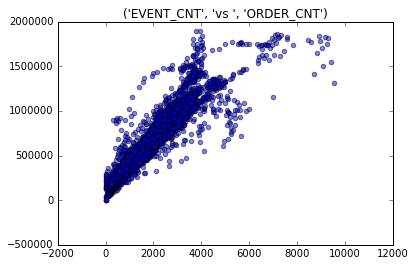

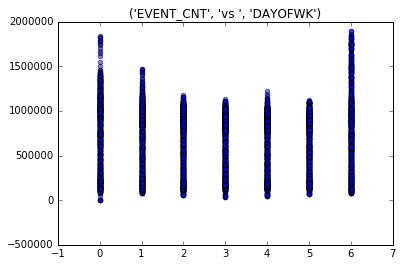

In [14]:
import matplotlib.pyplot as plt

y = df.ix[:,0]

for z in range(3,l1):
    x = df.ix[:,z]
    plt.scatter(x, y, alpha=0.5)
    ttl = df.columns[0].upper(), 'vs ', df.columns[z].upper()
    plt.title(ttl)
    plt.show()



In [15]:
formula = "event_cnt ~ C(dayofwk)"
# create a results dictionary to hold our regression results for easy analysis later        
results = {}

In [16]:
desc = ModelDesc.from_formula(formula)
desc.describe()

'event_cnt ~ C(dayofwk)'

In [17]:
print formula
y,x = dmatrices(desc.describe(),data=df,return_type='dataframe')

event_cnt ~ C(dayofwk)


In [18]:
model = sm.OLS(y,x)

# fit our model to the training data
res_v = model.fit().params.values
#res = res_v = model.fit()
print res_v
print model

[ 769064.54398148  -85484.84143519 -109027.79166667 -130490.71180555
 -138533.95717593 -130898.28472222   35885.07291667]


In [19]:
feature_cols = df.columns[4:]

# define X (features) and y (response)
X = df[feature_cols]
y = df.event_cnt

In [20]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [21]:
from sklearn.tree import DecisionTreeRegressor
treereg = DecisionTreeRegressor(random_state=1)
treereg.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=1,
           splitter='best')

In [22]:
preds = treereg.predict(X_test)

# print predictions and actual values
print preds[0:10]
print y_test[0:10]

[  594846.   832529.   326058.  1776672.  1134775.   297445.   530520.
   826054.   965379.   763100.]
1056     595652
301      819959
2420     327024
3509    1801580
3168    1144516
2776     297973
234      523965
2719     810006
5849     959942
5635     751809
Name: event_cnt, dtype: int64


In [23]:
# print RMSE
from sklearn import metrics
import numpy as np
np.sqrt(metrics.mean_squared_error(y_test, preds))

12226.285093106166

In [24]:
# use cross-validation to find best max_depth
from sklearn.cross_validation import cross_val_score

In [25]:
# try max_depth=9
treereg = DecisionTreeRegressor(max_depth=9, random_state=1)
scores = cross_val_score(treereg, X, y, cv=3, scoring='mean_squared_error')
np.mean(np.sqrt(-scores))

37049.154393307304

In [26]:
# max_depth=10 was best, so fit a tree using that parameter with ALL DATA
treereg = DecisionTreeRegressor(max_depth=9, random_state=1)
treereg.fit(X, y)
pd.DataFrame({'feature':feature_cols, 'importance':treereg.feature_importances_ * 10})
imp = pd.DataFrame({'feature':feature_cols, 'importance':treereg.feature_importances_ * 10})
imp_srtd = imp.sort_values(by=['importance'],ascending=False)
print imp_srtd
tot_imp = imp_srtd['importance'].sum()
imp_srtd['pct'] = imp_srtd['importance'] / tot_imp * 100
imp_srtd['c_pct'] = imp_srtd['pct'].cumsum()

df_f = imp_srtd.loc[imp_srtd['c_pct'] <= 99.85]
l2 = len(df_f)

for i in range(0,l2):
    if i == 0:
        f = df_f.iloc[i,0]
    else:
        f = f + '+' + df_f.iloc[i,0]
        
f2 = list(df)[0] + '~' + f



          feature  importance
22       pgld_cnt    9.122095
11       mweb_cnt    0.804066
25      click_cnt    0.030545
10     android_os    0.018240
14  srch_rslt_cnt    0.005276
1    unq_visitors    0.005183
2          unq_ip    0.002078
24        rec_cnt    0.002071
13       pgvw_cnt    0.001967
15     homepg_cnt    0.001368
4      sign_in_no    0.001100
18       lvl1_cnt    0.000970
23        atp_cnt    0.000960
26       tcin_cnt    0.000832
7       iphone_os    0.000669
21       lvl4_cnt    0.000482
12   prod_dtl_cnt    0.000396
3     sign_in_rem    0.000269
6      windows_os    0.000262
5     sign_in_unk    0.000252
27     compld_cnt    0.000221
29      order_cnt    0.000211
16    shp_crt_cnt    0.000195
9         ipad_os    0.000120
8          mac_os    0.000073
20       lvl3_cnt    0.000030
19       lvl2_cnt    0.000026
28   demand_sales    0.000023
17  crt_ovrly_cnt    0.000019
0       event_min    0.000001
30        dayofwk    0.000000


In [27]:
formula = f2
# create a results dictionary to hold our regression results for easy analysis later        
results = {}

In [28]:
desc = ModelDesc.from_formula(formula)
desc.describe()

'event_cnt ~ pgld_cnt + mweb_cnt + click_cnt + android_os + srch_rslt_cnt'

In [29]:
print formula
y,x = dmatrices(desc.describe(),data=df,return_type='dataframe')

event_cnt~pgld_cnt+mweb_cnt+click_cnt+android_os+srch_rslt_cnt


In [30]:
model = sm.OLS(y,x)

# fit our model to the training data
results = model.fit()
res_v = model.fit().params.values
print results.params
print results.tvalues

results.summary()

Intercept        3152.533635
pgld_cnt            0.952979
mweb_cnt            0.528578
click_cnt           1.434917
android_os          0.193203
srch_rslt_cnt      -0.484747
dtype: float64
Intercept         11.677896
pgld_cnt         401.097177
mweb_cnt         164.637914
click_cnt         17.899405
android_os        25.088560
srch_rslt_cnt    -23.262770
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              event_cnt   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.910e+06
Date:                Wed, 21 Sep 2016   Prob (F-statistic):               0.00
Time:                        13:30:36   Log-Likelihood:                -63725.
No. Observations:                6048   AIC:                         1.275e+05
Df Residuals:                    6042   BIC:                         1.275e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept      3152.5336    269.957     11.678      0.000      2623.321  3681.746
pgld_cnt          0.9530      0.002    401.097      0.000         0.948     0.958
mweb_cnt          0.5286      0.003    164.638      0.000         0.522     0.535
click_cnt         1.4349      0.080     17.899      0.000         1.278     1.592
android_os        0.1932      0.008     25.089      0.000         0.178     0.208
srch_rslt_cnt    -0.4847      0.021    -23.263      0.000        -0.526    -0.444
==============================================================================
Omnibus:                      975.530   Durbin-Watson:                   1.487
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2568.299
Skew:                          -0.883   Prob(JB):                         0.00
Kurtosis:                       5.660   Cond. No.                     1.96e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.96e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [31]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.stats.outliers_influence import summary_table

prstd, iv_l, iv_u = wls_prediction_std(results)

st, data, ss2 = summary_table(results, alpha=0.05)

fittedvalues = data[:,2]
predict_mean_se  = data[:,3]
predict_mean_ci_low, predict_mean_ci_upp = data[:,4:6].T
predict_ci_low, predict_ci_upp = data[:,6:8].T

print np.max(np.abs(results.fittedvalues - fittedvalues))
print np.max(np.abs(iv_l - predict_ci_low))
print np.max(np.abs(iv_u - predict_ci_upp))

#x = 
y = f2

0.0
0.0
0.0


ValueError: x and y must have same first dimension

> c:\users\z087828\appdata\local\continuum\anaconda2\envs\py27\lib\site-packages\matplotlib\axes\_base.py(223)_xy_from_xy()
    221         y = _check_1d(y)
    222         if x.shape[0] != y.shape[0]:
--> 223             raise ValueError("x and y must have same first dimension")
    224         if x.ndim > 2 or y.ndim > 2:
    225             raise ValueError("x and y can be no greater than 2-D")

ipdb> q


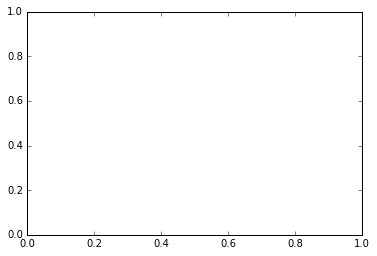

In [32]:
#http://stackoverflow.com/questions/17559408/confidence-and-prediction-intervals-with-statsmodels

plt.plot(x, y, 'o')
plt.plot(x, fittedvalues, '-', lw=2)
plt.plot(x, predict_ci_low, 'r--', lw=2)
plt.plot(x, predict_ci_upp, 'r--', lw=2)
plt.plot(x, predict_mean_ci_low, 'r--', lw=2)
plt.plot(x, predict_mean_ci_upp, 'r--', lw=2)
plt.show()

In [ ]:
import statsmodels.formula.api as smf
est = smf.ols(formula=desc.describe(), data=df2).fit()
est.summary()

In [ ]:
predictions = results.predict(df2)
predictions.summary()

In [ ]:
# calculate the number of rows in vehicles
n_rows = df.shape[0]

# set a seed for reproducibility
np.random.seed(123)

# create three bootstrap samples (will be used to select rows from the DataFrame)
sample1 = np.random.choice(a=n_rows, size=n_rows, replace=True)
sample2 = np.random.choice(a=n_rows, size=n_rows, replace=True)
sample3 = np.random.choice(a=n_rows, size=n_rows, replace=True)

In [ ]:
from sklearn.tree import DecisionTreeRegressor

# grow one regression tree with each bootstrapped training set
treereg1 = DecisionTreeRegressor(random_state=123)
treereg1.fit(df.iloc[sample1, 3:28], df.iloc[sample1, 29])

treereg2 = DecisionTreeRegressor(random_state=123)
treereg2.fit(df.iloc[sample2, 3:28], df.iloc[sample2, 29])

treereg3 = DecisionTreeRegressor(random_state=123)
treereg3.fit(df.iloc[sample3, 3:28], df.iloc[sample3, 29])

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfclf = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1)
rfclf.fit(df[feature_cols], df.event_cnt)

In [ ]:
# compute the feature importances
pd.DataFrame({'feature':feature_cols, 'importance':rfclf.feature_importances_})

In [ ]:
df.corr()

In [ ]:
# Stepwise

import statsmodels.formula.api as smf

def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

In [ ]:
df2 = y = df.ix[1:200,25:31]

model = forward_selected(df2,'event_cnt')

print model.model.formula
print model.rsquared_adj

In [33]:
lm = smf.ols(formula=model.model.formula, data=df).fit()

# print the coefficients
lm.params

NameError: name 'smf' is not defined

> <ipython-input-33-43ebee9ba4aa>(1)<module>()
----> 1 lm = smf.ols(formula=model.model.formula, data=df).fit()
      2 
      3 # print the coefficients
      4 lm.params

ipdb> q


In [34]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train, y_train)
lm.coef_

array([  1.22613025e-05,   3.29774114e-09,   1.40772867e-08,
        -1.11742487e-09,   3.19731805e-09,  -1.38974771e-07,
         3.10338443e-08,   5.85630852e-08,   9.49514917e-09,
         1.32736837e-07,  -1.04163437e-07,  -6.23635371e-09,
         2.79990030e-08,   9.02146532e-08,  -1.81584546e-09,
        -1.67960781e-07,   1.85787690e-07,  -9.76400842e-07,
        -2.15615817e-07,  -6.47779878e-08,  -4.93070049e-08,
        -2.68937335e-07,   1.00000006e+00,   9.99999784e-01,
         9.99999984e-01,   9.99999983e-01,   1.00000002e+00,
         9.99999702e-01,  -2.93636535e-08,   2.25583066e-07,
         2.79518422e-05])

In [35]:
# make predictions and evaluate
import numpy as np
from sklearn import metrics
preds = lm.predict(X_test)
np.sqrt(metrics.mean_squared_error(y_test, preds))

0.0017685501762825808

In [36]:
# ridge regression (alpha must be positive, larger means more regularization)
from sklearn.linear_model import Ridge
rreg = Ridge(alpha=0.1, normalize=True)
rreg.fit(X_train, y_train)
rreg.coef_
preds = rreg.predict(X_test)
np.sqrt(metrics.mean_squared_error(y_test, preds))

9505.8052401312034

In [37]:
# use RidgeCV to select best alpha
from sklearn.linear_model import RidgeCV
alpha_range = 10.**np.arange(-2, 3)
rregcv = RidgeCV(normalize=True, scoring='mean_squared_error', alphas=alpha_range)
rregcv.fit(X_train, y_train)
rregcv.alpha_
preds = rregcv.predict(X_test)
np.sqrt(metrics.mean_squared_error(y_test, preds))

4018.6965830764243

In [38]:
# lasso (alpha must be positive, larger means more regularization)
from sklearn.linear_model import Lasso
las = Lasso(alpha=0.01, normalize=True)
las.fit(X_train, y_train)
las.coef_
preds = las.predict(X_test)
np.sqrt(metrics.mean_squared_error(y_test, preds))

3901.1400163310454

In [39]:
# try a smaller alpha
las = Lasso(alpha=0.0001, normalize=True)
las.fit(X_train, y_train)
las.coef_
preds = las.predict(X_test)
np.sqrt(metrics.mean_squared_error(y_test, preds))

3902.3996228614415

In [40]:
# use LassoCV to select best alpha (tries 100 alphas by default)
from sklearn.linear_model import LassoCV
lascv = LassoCV(normalize=True)
lascv.fit(X_train, y_train)
lascv.alpha_
lascv.coef_
preds = lascv.predict(X_test)
np.sqrt(metrics.mean_squared_error(y_test, preds))

C:\Users\z087828\AppData\Local\Continuum\Anaconda2\envs\py27\lib\site-packages\sklearn\linear_model\coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


2886.3526848137958

In [41]:
import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn import datasets

X = df.ix[:,3:28]
y = df.ix[:,29]

rng = np.random.RandomState(42)
X = np.c_[X, rng.randn(X.shape[0], 14)]  # add some bad features

# normalize data as done by Lars to allow for comparison
X /= np.sqrt(np.sum(X ** 2, axis=0))

C:\Users\z087828\AppData\Local\Continuum\Anaconda2\envs\py27\lib\site-packages\sklearn\linear_model\least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 42 iterations, alpha=6.396e+00, previous alpha=1.834e-02, with an active set of 35 regressors.
  ConvergenceWarning)


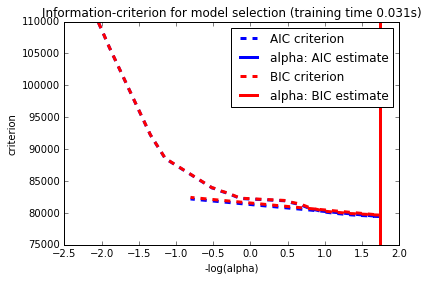

In [42]:
##############################################################################
# LassoLarsIC: least angle regression with BIC/AIC criterion

model_bic = LassoLarsIC(criterion='bic')
t1 = time.time()
model_bic.fit(X, y)
t_bic = time.time() - t1
alpha_bic_ = model_bic.alpha_

model_aic = LassoLarsIC(criterion='aic')
model_aic.fit(X, y)
alpha_aic_ = model_aic.alpha_


def plot_ic_criterion(model, name, color):
    alpha_ = model.alpha_
    alphas_ = model.alphas_
    criterion_ = model.criterion_
    plt.plot(-np.log10(alphas_), criterion_, '--', color=color,
             linewidth=3, label='%s criterion' % name)
    plt.axvline(-np.log10(alpha_), color=color, linewidth=3,
                label='alpha: %s estimate' % name)
    plt.xlabel('-log(alpha)')
    plt.ylabel('criterion')

plt.figure()
plot_ic_criterion(model_aic, 'AIC', 'b')
plot_ic_criterion(model_bic, 'BIC', 'r')
plt.legend()
plt.title('Information-criterion for model selection (training time %.3fs)'
          % t_bic)

Computing regularization path using the coordinate descent lasso...


(-6, 8)

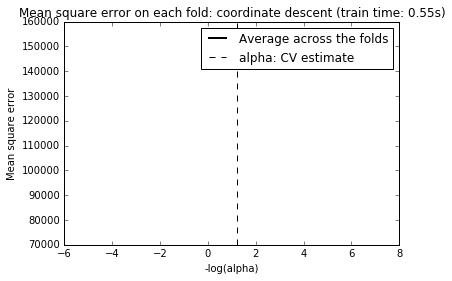

In [43]:
##############################################################################
# LassoCV: coordinate descent

# Compute paths
print("Computing regularization path using the coordinate descent lasso...")
t1 = time.time()
model = LassoCV(cv=20).fit(X, y)
t_lasso_cv = time.time() - t1

# Display results
m_log_alphas = -np.log10(model.alphas_)

plt.figure()
ymin, ymax = 70000,160000
xmin, xmax = -6, 8
plt.plot(m_log_alphas, model.mse_path_, ':')
plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha: CV estimate')

plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: coordinate descent '
          '(train time: %.2fs)' % t_lasso_cv)
plt.axis('tight')
plt.ylim(ymin, ymax)
plt.xlim(xmin,xmax)

Computing regularization path using the Lars lasso...


C:\Users\z087828\AppData\Local\Continuum\Anaconda2\envs\py27\lib\site-packages\sklearn\linear_model\least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 42 iterations, alpha=4.468e+00, previous alpha=1.238e-02, with an active set of 35 regressors.
  ConvergenceWarning)
C:\Users\z087828\AppData\Local\Continuum\Anaconda2\envs\py27\lib\site-packages\sklearn\linear_model\least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 45 iterations, alpha=1.778e+01, previous alpha=2.443e-02, with an active set of 36 regressors.
  ConvergenceWarning)
C:\Users\z087828\AppData\Local\Continuum\Anaconda2\envs\py27\lib\site-packages\sklearn\linear_model\least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well control

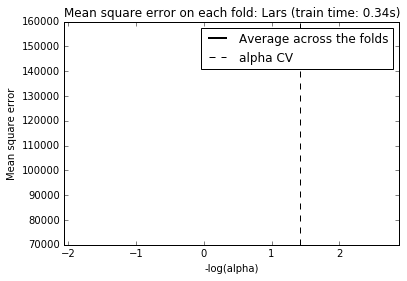

In [44]:
##############################################################################
# LassoLarsCV: least angle regression

# Compute paths
print("Computing regularization path using the Lars lasso...")
t1 = time.time()
model = LassoLarsCV(cv=20).fit(X, y)
t_lasso_lars_cv = time.time() - t1

# Display results
m_log_alphas = -np.log10(model.cv_alphas_)

plt.figure()
plt.plot(m_log_alphas, model.cv_mse_path_, ':')
plt.plot(m_log_alphas, model.cv_mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha CV')
plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: Lars (train time: %.2fs)'
          % t_lasso_lars_cv)
plt.axis('tight')
plt.ylim(ymin, ymax)

plt.show()